- Author: Peter Riesebos
- Purpose: Script used to inspect summary stats from multiple studies and compare them, plotting correlations, heatmaps, and UpSet graphs.
- Input: List of protein coding genes, mbQTL format summary stat files
- Output: graphs

## Library and file imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from upsetplot import UpSet, plot
from scipy.stats import pearsonr

### New method mbqtl output (using a pre-protein coding filtered and version stripped expression matrix)

In [5]:
# pub rna mbQTL output (summary stats) before and after qvalue filter
pub_rna_new_qvalue = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_exp_fixed/merged_topeffects_qvalue.txt", sep='\t')
pub_rna_new = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/mbqtl_output_pub_rna_exp_fixed/merged_topeffects_final.txt", sep='\t')

In [6]:
# 1000IBD (Werna) mbQTL output (summary stats) before and after qvalue filter
werna_new_qvalue = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/Werna/qtl/eqtl/output_exp_fixed/merged_topeffects_qvalue.txt", sep='\t')
werna_new = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/Werna/qtl/eqtl/output_exp_fixed/merged_topeffects_final.txt", sep='\t')

In [7]:
# GTEx mbQTL output (summary stats) before and after qvalue filter
gtex_new_qvalue = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_exp_fixed/merged_topeffects_qvalue.txt", sep='\t')
gtex_new = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_exp_fixed/merged_topeffects_final.txt", sep='\t')

In [8]:
# combined datasets mbQTL output (summary stats) before and after qvalue filter
combined_new_qvalue = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/combined/mbqtl_output_combined_exp_fixed/merged_topeffects_qvalue.txt", sep='\t')
combined_new = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/combined/mbqtl_output_combined_exp_fixed/merged_topeffects_final.txt", sep='\t')

In [9]:
# combined datasets mbQTL output (summary stats) before and after qvalue filter (without pub_rna)
combined_no_pub_qvalue = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/combined_no_pub_rna/merged_topeffects_qvalue.txt", sep='\t')
combined_no_pub = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/combined_no_pub_rna/merged_topeffects_final.txt", sep='\t')

### Top and All effect intersection files

In [10]:
werna_gtex = pd.read_csv('/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/werna_gtex_overlap.txt', sep='\t')
gtex_werna = pd.read_csv('/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/gtex_werna_overlap.txt', sep='\t')
pub_rna_werna = pd.read_csv('/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/pub_rna_werna_overlap.txt', sep='\t')
werna_pub_rna = pd.read_csv('/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/werna_pub_rna_overlap.txt', sep='\t')
pub_rna_gtex = pd.read_csv('/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/pub_rna_gtex_overlap.txt', sep='\t')
gtex_pub_rna = pd.read_csv('/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/gtex_pub_rna_overlap.txt', sep='\t')

### Old method mbqtl output files (filtering on protein coding genes after the mbQTL run, and no version numbering stripped)

In [2]:
# protein coding genes gencode v44
genes = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/final_files_pub_rna/protein_coding_genes_list.txt", names=["Gene"])
genes

Gene
0       ENSG00000186092.7
1       ENSG00000284733.2
2       ENSG00000284662.2
3      ENSG00000187634.13
4      ENSG00000188976.11
...                   ...
20065   ENSG00000277836.1
20066   ENSG00000278633.1
20067   ENSG00000276017.1
20068   ENSG00000278817.1
20069   ENSG00000277196.4

[20070 rows x 1 columns]

In [3]:
# mbqtl pub_rna summary stats
pub_rna = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/pub_rna/final_files_pub_rna/pub_rna_100perm_30_cutoff_maf_0.05/merged_topEffects_final.txt", sep="\t")
pub_rna

Gene  GeneChr    GenePos GeneStrand          GeneSymbol  \
0      ENSG00000204792.2        2   74918148          +   ENSG00000204792.2   
1     ENSG00000226752.10        9  120824828          +  ENSG00000226752.10   
2     ENSG00000258289.10       14   64914361          +  ENSG00000258289.10   
3     ENSG00000121716.21        7  100352176          +  ENSG00000121716.21   
4     ENSG00000196862.10        2  107826892          +  ENSG00000196862.10   
...                  ...      ...        ...        ...                 ...   
4607  ENSG00000228262.11        2   33706886          +  ENSG00000228262.11   
4608  ENSG00000110881.12       12   50057548          +  ENSG00000110881.12   
4609  ENSG00000117153.16        1  202891116          -  ENSG00000117153.16   
4610   ENSG00000257431.1       12   82512677          +   ENSG00000257431.1   
4611   ENSG00000276718.1       12    6466537          +   ENSG00000276718.1   

              SNP  SNPChr     SNPPos SNPAlleles SNPEffectAllele  ...  \
0      rs12713826       2   75041011        T/A               A  ...   
1      rs12684934       9  120830881        C/T               T  ...   
2      rs11158569      14   64933351        C/T               T  ...   
3       rs7792525       7  100374499        A/G               G  ...   
4      rs11123707       2  108566901        G/A               A  ...   
...           ...     ...        ...        ...             ...  ...   
4607    rs1470611       2   33671049        C/A               A  ...   
4608  rs386376466      12   50128488     C/CAAA            CAAA  ...   
4609    rs7539542       1  202940846        G/C               C  ...   
4610   rs11358515      12   82432863       TA/T               T  ...   
4611    rs2364498      12    6503786        T/A               A  ...   

      DatasetCorrelationCoefficients.ERP113396.ERP114636.SRP063496.SRP068609.SRP077046.SRP096757.SRP129004.SRP155976.SRP189239.  \
0     -;-;0.744204;0.554869;0.764917;0.824807;0.8929...                                                                           
1     -;-0.656852;-0.840908;-0.525352;-0.743613;-;-0...                                                                           
2     -;-;0.82668;-;0.653926;0.782285;0.804819;0.831...                                                                           
3     -;0.790385;0.779892;-;0.718911;0.751346;0.7451...                                                                           
4     -;0.557069;0.675051;0.645076;0.746054;0.743858...                                                                           
...                                                 ...                                                                           
4607                  -;-;-;-;-0.377367;-;-;-;-0.507666                                                                           
4608  -0.21666;-0.287802;-0.151555;-0.02799;0.086965...                                                                           
4609  -;-;0.30794;0.584245;-0.046837;-;0.240089;-;0....                                                                           
4610                  -;-;-;-;-;-;-0.236501;-;-0.238909                                                                           
4611  -0.238959;-0.138431;-0.020657;-0.480214;-0.021...                                                                           

     DatasetZScores.ERP113396.ERP114636.SRP063496.SRP068609.SRP077046.SRP096757.SRP129004.SRP155976.SRP189239.  \
0     -;-;6.694893;3.064522;6.798465;14.189217;17.11...                                                          
1     -;-4.285708;-8.259505;-2.87077;-6.503607;-;-16...                                                          
2     -;-;7.993022;-;5.413564;12.927695;13.838477;11...                                                          
3     -;5.647567;7.214328;-;6.181571;12.114261;12.19...                                                          
4     -;3.475933;5.811565;3.706117;6.536538;11.92781...        

In [4]:
# mbqtl 1000IBD summary stats
werna = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/Werna/qtl/eqtl/output/1000ibd_merged_topeffects_final.txt", sep="\t")
werna

Gene  GeneChr    GenePos GeneStrand          GeneSymbol  \
0     ENSG00000155957.19       12   66135846          -  ENSG00000155957.19   
1      ENSG00000254851.1       11  117135528          +   ENSG00000254851.1   
2      ENSG00000277149.5        7   72558744          -   ENSG00000277149.5   
3      ENSG00000278266.1       12  127147149          +   ENSG00000278266.1   
4     ENSG00000171903.17       19   15912367          -  ENSG00000171903.17   
...                  ...      ...        ...        ...                 ...   
1211   ENSG00000288784.1        7  144183466          +   ENSG00000288784.1   
1212  ENSG00000163389.12        3  119468963          +  ENSG00000163389.12   
1213  ENSG00000184730.12       16   28494643          +  ENSG00000184730.12   
1214   ENSG00000236981.1       11  124023013          +   ENSG00000236981.1   
1215   ENSG00000286596.1        4   30718805          -   ENSG00000286596.1   

               SNP  SNPChr     SNPPos SNPAlleles SNPEffectAllele  ...  \
0       rs17767200      12   66143554        A/G               G  ...   
1         rs236910      11  117211258        A/G               G  ...   
2        rs6947199       7   72743715        A/G               G  ...   
3       rs11058961      12  127060453        G/A               A  ...   
4       rs12985091      19   15934939        G/A               A  ...   
...            ...     ...        ...        ...             ...  ...   
1211  rs1277668795       7  143886866      ATT/A               A  ...   
1212     rs1797839       3  119531024        T/C               C  ...   
1213      rs181209      16   28503533        G/T               T  ...   
1214    rs76000277      11  123126109        G/A               A  ...   
1215    rs61793244       4   31296424        C/A               A  ...   

      DatasetCorrelationCoefficients.1000IBD. DatasetZScores.1000IBD.  \
0                                   -0.828067              -15.573369   
1                                    0.831346               15.690419   
2                                   -0.816480              -15.172103   
3                                    0.777615               13.945170   
4                                   -0.772235              -13.787412   
...                                       ...                     ...   
1211                                 0.335221                4.997380   
1212                                -0.341862               -5.102727   
1213                                 0.320967                4.772596   
1214                                -0.322202               -4.792008   
1215                                 0.327646                4.877704   

      DatasetSampleSizes.1000IBD.  NrTestedSNPs  ProportionBetterPermPvals  \
0                             212          3617                        0.0   
1                             212          4662                        0.0   
2                             212          3459                        0.0   
3                             212          5606                        0.0   
4                             212          6539                        0.0   
...                           ...           ...                        ...   
1211                          212          3391                        0.0   
1212                          212          4463                        0.0   
1213                          212          3307                        0.0   
1214                          212          5987                        0.0   
1215                          212          4491                        0.0   

      BetaDistAlpha  BetaDistBeta  BetaAdjustedMetaP  PvalueNominalThreshold  \
0          0.929257    335.619701       1.657916e-48            2.442690e-06   
1          0.816410    669.767333       4.300551e-43            4.373510e-07   
2          0.831267    233.065154       2.390197e-41            1.461780e-06   
3          0.979991    804.333083       1.769858e-40        

In [5]:
# mbqtl 1000IBD summary stats
gtex = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbQTL_output/GTEx_colon_small_final.txt", sep="\t")
gtex

Gene  GeneChr    GenePos GeneStrand         GeneSymbol  \
0     ENSG00000204792.2        2   74918148          +  ENSG00000204792.2   
1     ENSG00000270127.2       15  100547765          -  ENSG00000270127.2   
2     ENSG00000236209.1        2   74919555          -  ENSG00000236209.1   
3     ENSG00000254614.2       11   65177606          -  ENSG00000254614.2   
4     ENSG00000273295.1       22   23901432          -  ENSG00000273295.1   
...                 ...      ...        ...        ...                ...   
1852  ENSG00000273172.1       17     183824          -  ENSG00000273172.1   
1853  ENSG00000263232.2       16   72005037          -  ENSG00000263232.2   
1854  ENSG00000167768.4       12   52674736          -  ENSG00000167768.4   
1855  ENSG00000279187.1       17   81262920          +  ENSG00000279187.1   
1856  ENSG00000250376.1        4   68784618          +  ENSG00000250376.1   

                SNP  SNPChr     SNPPos SNPAlleles SNPEffectAllele  ...  \
0           rs12366       2   74958729        G/T               T  ...   
1        rs36053285      15  100574435        T/C               C  ...   
2           rs12366       2   74958729        G/T               T  ...   
3        rs12800339      11   65179769        T/C               C  ...   
4         rs5751777      22   23924860        C/T               T  ...   
...             ...     ...        ...        ...             ...  ...   
1852  17:201297:C:T      17     201297        C/T               T  ...   
1853      rs4556810      16   72999574        C/A               A  ...   
1854      rs1567759      12   52697782        C/A               A  ...   
1855      rs7224668      17   81261988        T/C               C  ...   
1856     rs13121671       4   68625465        G/T               T  ...   

      DatasetCorrelationCoefficients.GTEx_Colon_Transverse.GTEx_Small_Intestine.  \
0                                     0.880422;0.844401                            
1                                   -0.811839;-0.778316                            
2                                      0.82331;0.826306                            
3                                   -0.804084;-0.863772                            
4                                     0.784523;0.830106                            
...                                                 ...                            
1852                                  0.197503;0.307728                            
1853                                -0.196508;-0.311467                            
1854                                   0.18572;0.379869                            
1855                                 0.230089;-0.034816                            
1856                                  0.189748;0.222609                            

     DatasetZScores.GTEx_Colon_Transverse.GTEx_Small_Intestine.  \
0                                      23.196152;7.1151           
1                                  -19.697398;-6.143089           
2                                    20.208727;6.823381           
3                                  -19.364157;-7.456511           
4                                    18.563044;6.882745           
...                                                 ...           
1852                                  3.787334;2.007452           
1853                                -3.767863;-2.033125           
1854                                  3.557229;2.512535           
1855                                  4.428212;-0.22164           
1856                                  3.635808;1.434806           

      DatasetSampleSizes.GTEx_Colon_Transverse.GTEx_Small_Intestine.  \
0                                                363;43                
1                                                363;43                
2                                                363;43                
3                                                363;43                
4                              

In [30]:
# mbqtl 1000IBD summary stats
all_studies = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/combined/combined_datasets_merged_final.txt", sep="\t")
all_studies

Gene  GeneChr    GenePos GeneStrand       GeneSymbol  \
0      ENSG00000204792        2   74918148          +  ENSG00000204792   
1      ENSG00000254851       11  117135528          +  ENSG00000254851   
2      ENSG00000164308        5   96875986          +  ENSG00000164308   
3      ENSG00000165171        7   73834590          -  ENSG00000165171   
4      ENSG00000214401       17   46193566          +  ENSG00000214401   
...                ...      ...        ...        ...              ...   
10419  ENSG00000236493       10   92668745          -  ENSG00000236493   
10420  ENSG00000133275       19    1941172          +  ENSG00000133275   
10421  ENSG00000273957        5  100388853          +  ENSG00000273957   
10422  ENSG00000267472       17   68198921          +  ENSG00000267472   
10423  ENSG00000182742       17   48575507          -  ENSG00000182742   

                           SNP  SNPChr     SNPPos              SNPAlleles  \
0                      rs12366       2   74958729                     G/T   
1                   rs35186251      11  117205992                     T/C   
2                   rs35304156       5   96983311                   CAT/C   
3                       rs8629       7   73831189                     T/C   
4                     rs169201      17   46712837                     A/G   
...                        ...     ...        ...                     ...   
10419             rs1338806625      10   92637032                    CA/C   
10420  19:1963042:G:GCCAGGCTCA      19    1963042  G/GCCAGGCTCAATGAGACACT   
10421                 rs276465       5  100770898                     A/T   
10422                rs8067476      17   68216846                     T/C   
10423                rs2411978      17   49275857                     A/G   

            SNPEffectAllele  ...  \
0                         T  ...   
1                         C  ...   
2                         C  ...   
3                         C  ...   
4                         G  ...   
...                     ...  ...   
10419                     C  ...   
10420  GCCAGGCTCAATGAGACACT  ...   
10421                     T  ...   
10422                     C  ...   
10423                     G  ...   

       DatasetCorrelationCoefficients.1000IBD.ERP113396.ERP114636.GTEx_Colon_Transverse.GTEx_Small_Intestine.SRP063496.SRP068609.SRP077046.SRP096757.SRP129004.SRP155976.SRP189239.  \
0      0.775618;-;-;0.880422;0.844401;0.742203;0.5267...                                                                                                                              
1      0.830863;0.680283;0.700251;0.714185;0.775487;0...                                                                                                                              
2      0.798882;-;0.51394;0.845427;0.868714;0.749766;...                                                                                                                              
3      -0.742649;-0.466703;-0.596777;-0.814443;-0.789...                                                                                                                              
4      0.709041;0.703406;0.520276;0.716104;0.754089;-...                                                                                                                              
...                                                  ...                                                                                                                              
10419        0.06438;-;-;0.225066;0.387544;-;-;-;-;-;-;-                                                                                                                              
10420  -0.1058;-0.067433;-0.272574;-0.292515;-0.05967...                                                                                                                              
10421  -0.205742;-;-;-;-;-0.054607;-;-0.012572;-;-0.1...                                                                    

Before filtering we find:
- 1857 eGenes in GTEx (406 samples)
- 1216 eGenes in 1000IBD (227 samples)
- 4612 eGenes in pub rna (724 samples)

## Data inspection

In [36]:
pub_rna_new.sort_values(by="GeneChr")

Gene  GeneChr    GenePos GeneStrand       GeneSymbol  \
3253  ENSG00000184389        1   33306766          -  ENSG00000184389   
3263  ENSG00000162783        1  181088700          +  ENSG00000162783   
1381  ENSG00000264343        1  146146203          -  ENSG00000264343   
1202  ENSG00000188295        1  247099962          -  ENSG00000188295   
1210  ENSG00000186510        1   16018875          +  ENSG00000186510   
...               ...      ...        ...        ...              ...   
2123  ENSG00000100253       22   50486784          +  ENSG00000100253   
2073  ENSG00000242247       22   42796502          -  ENSG00000242247   
3316  ENSG00000100030       22   21759657          -  ENSG00000100030   
3408  ENSG00000183762       22   29073035          +  ENSG00000183762   
804   ENSG00000100225       22   32474676          +  ENSG00000100225   

               SNP  SNPChr     SNPPos SNPAlleles SNPEffectAllele  ...  \
3253    rs11802938       1   33250553        G/A               A  ...   
3263     rs3842829       1  180158613        C/T               T  ...   
1381  rs1259144030       1  146028748       CT/C               C  ...   
1202     rs6702419       1  247087833        C/T               T  ...   
1210      rs761759       1   16015855        A/T               T  ...   
...            ...     ...        ...        ...             ...  ...   
2123     rs2076713      22   50456420        G/A               A  ...   
2073    rs71186543      22   42824031      C/CTT             CTT  ...   
3316    rs13055161      22   22376778        G/A               A  ...   
3408    rs11704960      22   28993214        A/T               T  ...   
804      rs5754121      22   32505471        T/G               G  ...   

      DatasetCorrelationCoefficients.ERP113396.ERP114636.SRP063496.SRP068609.SRP077046.SRP096757.SRP129004.SRP155976.SRP189239.  \
3253                     -;-;-;-;0.065769;-;0.30112;-;-                                                                           
3263  -;0.152051;0.244724;-0.03386;0.188055;-;0.1840...                                                                           
1381  -;-;-;-0.151081;0.051073;-0.137497;-0.376399;-...                                                                           
1202             -;-;-;-;0.175091;-;0.372188;-;0.347034                                                                           
1210  -;-;0.154376;0.189981;0.110673;-;0.36255;-;0.1...                                                                           
...                                                 ...                                                                           
2123      -;-;0.062446;-;-;0.228824;0.303658;0.083394;-                                                                           
2073  0.337175;0.146985;0.064729;0.503173;0.18605;0....                                                                           
3316      -;-;0.369664;-;0.075929;0.209955;0.141705;-;-                                                                           
3408          -;-;-;-;-0.158884;-;-0.271052;-;-0.207173                                                                           
804   -;-;0.095126;0.211013;0.373796;0.160386;0.3549...                                                                           

     DatasetZScores.ERP113396.ERP114636.SRP063496.SRP068609.SRP077046.SRP096757.SRP129004.SRP155976.SRP189239.  \
3253                     -;-;-;-;0.47707;-;4.176388;-;-                                                          
3263  -;0.871961;1.851452;-0.17105;1.374919;-;2.5152...                                                          
1381  -;-;-;-0.767416;0.37031;-1.835425;-5.294809;-1...                                                          
1202             -;-;-;-;1.278585;-;5.230897;-;2.073658                                                          
1210  -;-;1.157052;0.968309;0.804394;-;5.085272;-;1....                                                          
...   

In [34]:
gtex_pub_rna.sort_values(by="GeneChr")

Gene  GeneChr     GenePos GeneStrand       GeneSymbol  \
4231  ENSG00000143001        1  54980628.0          +  ENSG00000143001   
4232  ENSG00000187642        1    975198.0          -  ENSG00000187642   
4233  ENSG00000228594        1   1598012.0          -  ENSG00000228594   
4234  ENSG00000158825        1  20589086.0          +  ENSG00000158825   
4235  ENSG00000043514        1  39838110.0          -  ENSG00000043514   
...               ...      ...         ...        ...              ...   
1034  ENSG00000100228       22  23145366.0          +  ENSG00000100228   
1035  ENSG00000183307       22  17116297.0          -  ENSG00000183307   
1036  ENSG00000239282       22  30285117.0          -  ENSG00000239282   
1037  ENSG00000100336       22  36189124.0          -  ENSG00000100336   
1026  ENSG00000128218       22  23752743.0          -  ENSG00000128218   

              SNP  SNPChr    SNPPos   SNPAlleles SNPEffectAllele  ...  \
4231    rs2433673     1.0  54977932          C/G               G  ...   
4232   rs28477686     1.0    975014          C/T               T  ...   
4233   rs28401288     1.0   1639348          G/T               T  ...   
4234     rs532545     1.0  20588679          C/T               T  ...   
4235   rs11589146     1.0  39829736          G/A               A  ...   
...           ...     ...       ...          ...             ...  ...   
1034    rs6003525    22.0  23154358          T/C               C  ...   
1035  rs751935295    22.0  17130697  T/TTTTCTTTC       TTTTCTTTC  ...   
1036    rs5749082    22.0  30374614          T/A               A  ...   
1037     rs132717    22.0  36200606          C/T               T  ...   
1026     rs131442    22.0  23766790          A/G               G  ...   

      MetaBeta    MetaSE    MetaI2  NrDatasets  \
4231 -0.532316  0.094735  0.160818         3.0   
4232 -0.122683  0.090031  0.000000         3.0   
4233  0.092167  0.071795  0.457737         6.0   
4234  0.448361  0.054147  0.663758         8.0   
4235  0.247070  0.079318  0.361098         5.0   
...        ...       ...       ...         ...   
1034 -0.134347  0.105660  0.000000         2.0   
1035 -0.223177  0.079077  0.000000         4.0   
1036 -0.002280  0.099215  0.156472         3.0   
1037 -0.238344  0.076671  0.000000         4.0   
1026 -0.274557  0.088427  0.000000         4.0   

      DatasetCorrelationCoefficients(ERP113396;ERP114636;SRP063496;SRP068609;SRP077046;SRP096757;SRP129004;SRP155976;SRP189239)  \
4231          -;-;-;-;-0.160227;-;-0.381546;-;-0.324156                                                                           
4232            -;-;-;-;-0.1428;-;-0.040464;-;-0.213112                                                                           
4233  -;-;0.13914;-0.082976;0.050909;0.125532;0.0722...                                                                           
4234  0.027695;-;0.238099;-0.042748;0.191701;0.38718...                                                                           
4235  0.303242;-;0.140313;-;0.219673;-;0.203242;-;-0...                                                                           
...                                                 ...                                                                           
1034                  -;-;-;-;-;-;-0.083458;-;-0.100509                                                                           
1035  -;-;-0.178697;-;-0.197369;-;-0.094508;-;-0.367343                                                                           
1036            -;-;-;-;-0.182712;-;0.030531;-;0.111309                                                                           
1037   -;-;-0.15773;-;-0.114751;-;-0.201139;-;-0.119391                                                                           
1026  -;-;-0.311562;-;-0.097646;-0.103013;-;-0.181207;-                                                                           

      DatasetZScores(ERP113396;ERP114636;SRP063496;SRP068609;SRP077046;SRP096

### Remaining eGenes after filtering on protein coding genes (old, no longer used)

In [7]:
intersect_pub_rna = set(pub_rna["Gene"]) & set(genes["Gene"])
print(len(intersect_pub_rna))

2820


In [8]:
intersect_werna = set(werna["Gene"]) & set(genes["Gene"])
print(len(intersect_werna))

737


In [9]:
intersect_gtex = set(gtex["Gene"]) & set(genes["Gene"])
print(len(intersect_gtex))

150


After filtering on protein coding genes we find:
- 150 eGenes in GTEx (406 samples)
- 737 eGenes in 1000IBD (227 samples)
- 2820 eGenes in pub rna (724 samples)

## Dataset cleanup and preparations

In [7]:
filtered_mbqtl = pub_rna_new.copy()
filtered_mbqtl

Gene  GeneChr    GenePos GeneStrand       GeneSymbol  \
0     ENSG00000258289       14   64914361          +  ENSG00000258289   
1     ENSG00000121716        7  100352176          +  ENSG00000121716   
2     ENSG00000196862        2  107826892          +  ENSG00000196862   
3     ENSG00000164308        5   96875986          +  ENSG00000164308   
4     ENSG00000165171        7   73834590          -  ENSG00000165171   
...               ...      ...        ...        ...              ...   
3416  ENSG00000242950        7   92468380          -  ENSG00000242950   
3417  ENSG00000145020        3   49416778          -  ENSG00000145020   
3418  ENSG00000100285       22   29480218          +  ENSG00000100285   
3419  ENSG00000165097        6   18155329          +  ENSG00000165097   
3420  ENSG00000196693       10   42574185          -  ENSG00000196693   

             SNP  SNPChr     SNPPos SNPAlleles SNPEffectAllele  ...  \
0     rs11158569      14   64933351        C/T               T  ...   
1      rs7792525       7  100374499        A/G               G  ...   
2     rs11123707       2  108566901        G/A               A  ...   
3     rs35304156       5   96983311      CAT/C               C  ...   
4     rs11284359       7   73832811       TA/T               T  ...   
...          ...     ...        ...        ...             ...  ...   
3416   rs2190507       7   92545231        T/C               C  ...   
3417  rs10575617       3   49773980      AAC/A               A  ...   
3418   rs2857629      22   29700885        G/T               T  ...   
3419  rs13199975       6   18167848        G/A               A  ...   
3420  rs72274564      10   42673559      CTG/C               C  ...   

      DatasetCorrelationCoefficients.ERP113396.ERP114636.SRP063496.SRP068609.SRP077046.SRP096757.SRP129004.SRP155976.SRP189239.  \
0     -;-;0.82668;-;0.653926;0.782285;0.804819;0.831...                                                                           
1     -;0.790385;0.779892;-;0.718911;0.751346;0.7451...                                                                           
2     -;0.557069;0.675051;0.645076;0.746054;0.743858...                                                                           
3     -;0.51394;0.749766;-;0.822442;0.725984;0.87741...                                                                           
4     -0.467706;-0.595068;-0.619319;-0.751967;-0.732...                                                                           
...                                                 ...                                                                           
3416                     -;-;-;-;0.42919;-;0.198407;-;-                                                                           
3417  0.078873;0.249809;0.246759;-;0.236724;0.090614...                                                                           
3418              -;-;-;-;0.317537;-;0.248216;-;0.15273                                                                           
3419  -;-;-;-0.10377;-0.048385;-;-0.182847;-0.332042...                                                                           
3420                  -;-;-;-;-;-;-0.275132;-;-0.179728                                                                           

     DatasetZScores.ERP113396.ERP114636.SRP063496.SRP068609.SRP077046.SRP096757.SRP129004.SRP155976.SRP189239.  \
0     -;-;7.993022;-;5.413564;12.927695;13.838477;11...                                                          
1     -;5.647567;7.214328;-;6.181571;12.114261;12.19...                                                          
2     -;3.475933;5.811565;3.706117;6.536538;11.92781...                                                          
3     -;3.158018;6.772461;-;7.699995;11.497036;16.42...                                                          
4     -2.699243;-3.77041;-5.182763;-4.613664;-6.3519...                                                          
...                           

In [8]:
# ERP113396.ERP114636.SRP063496.SRP068609.SRP077046.SRP096757.SRP129004.SRP155976.SRP189239
filtered_mbqtl.columns = ['Gene', 'GeneChr', 'GenePos', 'GeneStrand', 'GeneSymbol', 'SNP',
       'SNPChr', 'SNPPos', 'SNPAlleles', 'SNPEffectAllele',
       'SNPEffectAlleleFreq', 'QTLType', 'MetaP', 'MetaPN', 'MetaPZ',
       'MetaBeta', 'MetaSE', 'MetaI2', 'NrDatasets',
       'DatasetCorrelationCoefficients',
       'DatasetZScores',
       'DatasetSampleSizes',
       'NrTestedSNPs', 'ProportionBetterPermPvals', 'BetaDistAlpha',
       'BetaDistBeta', 'BetaAdjustedMetaP', 'PvalueNominalThreshold', 'qval']
filtered_mbqtl = filtered_mbqtl.reset_index()
filtered_mbqtl.head(5)

index             Gene  GeneChr    GenePos GeneStrand       GeneSymbol  \
0      0  ENSG00000258289       14   64914361          +  ENSG00000258289   
1      1  ENSG00000121716        7  100352176          +  ENSG00000121716   
2      2  ENSG00000196862        2  107826892          +  ENSG00000196862   
3      3  ENSG00000164308        5   96875986          +  ENSG00000164308   
4      4  ENSG00000165171        7   73834590          -  ENSG00000165171   

          SNP  SNPChr     SNPPos SNPAlleles  ...  \
0  rs11158569      14   64933351        C/T  ...   
1   rs7792525       7  100374499        A/G  ...   
2  rs11123707       2  108566901        G/A  ...   
3  rs35304156       5   96983311      CAT/C  ...   
4  rs11284359       7   73832811       TA/T  ...   

                      DatasetCorrelationCoefficients  \
0  -;-;0.82668;-;0.653926;0.782285;0.804819;0.831...   
1  -;0.790385;0.779892;-;0.718911;0.751346;0.7451...   
2  -;0.557069;0.675051;0.645076;0.746054;0.743858...   
3  -;0.51394;0.749766;-;0.822442;0.725984;0.87741...   
4  -0.467706;-0.595068;-0.619319;-0.751967;-0.732...   

                                      DatasetZScores  \
0  -;-;7.993022;-;5.413564;12.927695;13.838477;11...   
1  -;5.647567;7.214328;-;6.181571;12.114261;12.19...   
2  -;3.475933;5.811565;3.706117;6.536538;11.92781...   
3  -;3.158018;6.772461;-;7.699995;11.497036;16.42...   
4  -2.699243;-3.77041;-5.182763;-4.613664;-6.3519...   

              DatasetSampleSizes  NrTestedSNPs  ProportionBetterPermPvals  \
0     -;-;58;-;55;179;186;116;36          1677                        0.0   
1    -;35;58;-;55;179;186;116;36          2764                        0.0   
2   -;35;58;28;55;179;186;116;36           963                        0.0   
3    -;35;58;-;55;179;186;116;36          1671                        0.0   
4  32;35;58;28;55;179;186;116;36          1057                        0.0   

   BetaDistAlpha  BetaDistBeta  BetaAdjustedMetaP  PvalueNominalThreshold  \
0       0.835944    111.704155      6.165525e-110                0.000062   
1       0.901574    239.778737      1.317501e-106                0.000043   
2       0.906515     19.489434      6.792753e-102                0.000541   
3       0.781309     76.946810       7.958886e-96                0.000063   
4       0.833217     86.466338       1.020071e-95                0.000079   

            qval  
0  6.342270e-106  
1  6.776349e-103  
2   2.329160e-98  
3   2.046760e-92  
4   2.098626e-92  

[5 rows x 30 columns]

## Plotting

### UpSet plots

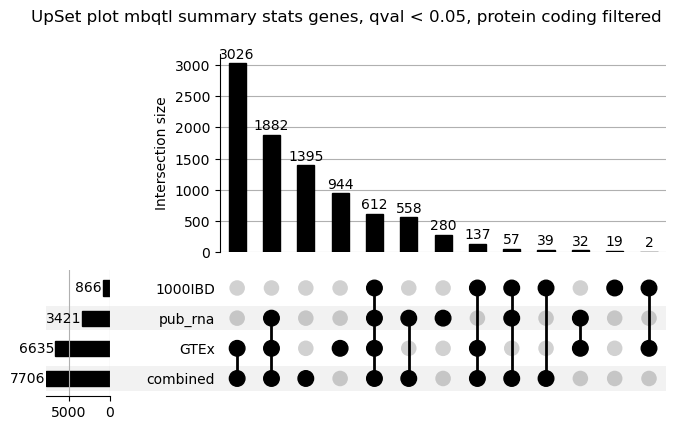

In [11]:
# upset plot of all datasets (gtex, werna, pub)
set1 = set(pub_rna_new["Gene"])
set2 = set(werna_new["Gene"])
set3 = set(gtex_new["Gene"])
set4 = set(combined_new["Gene"])

set_names = ['pub_rna', '1000IBD', 'GTEx', 'combined']
all_elems = set1.union(set2).union(set3).union(set4)
all_genes_set = pd.DataFrame([[e in set1, e in set2, e in set3, e in set4] for e in all_elems], columns = set_names)
df_up = all_genes_set.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True, sort_by="cardinality")
plt.suptitle("UpSet plot mbqtl summary stats genes, qval < 0.05, protein coding filtered")
plt.show()

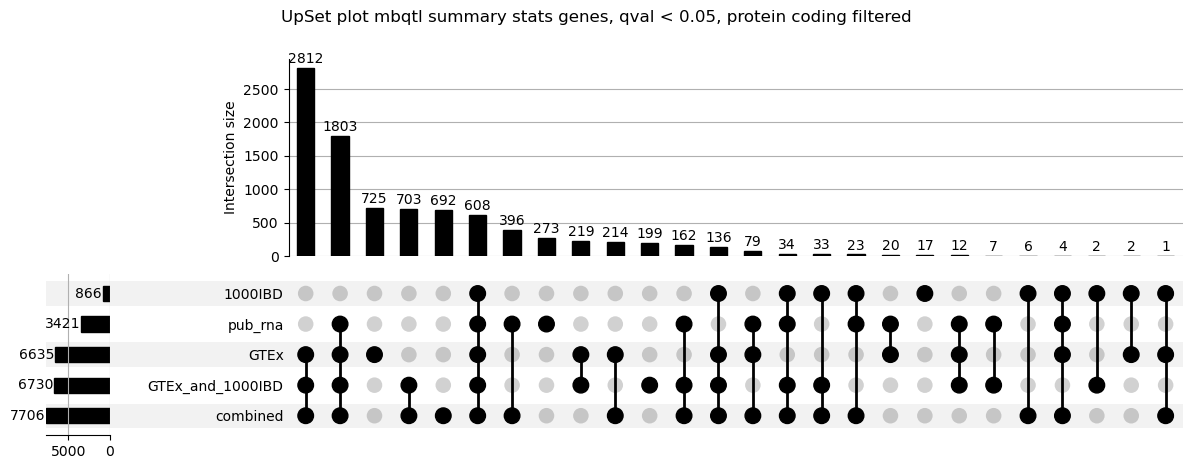

In [12]:
# upset plot of all datasets (gtex, werna, pub)
set1 = set(pub_rna_new["Gene"])
set2 = set(werna_new["Gene"])
set3 = set(gtex_new["Gene"])
set4 = set(combined_new["Gene"])
set5 = set(combined_no_pub["Gene"])

set_names = ['pub_rna', '1000IBD', 'GTEx', 'combined', 'GTEx_and_1000IBD']
all_elems = set1.union(set2).union(set3).union(set4).union(set5)
all_genes_set = pd.DataFrame([[e in set1, e in set2, e in set3, e in set4, e in set5] for e in all_elems], columns = set_names)
df_up = all_genes_set.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True, sort_by="cardinality")
plt.suptitle("UpSet plot mbqtl summary stats genes, qval < 0.05, protein coding filtered")
plt.show()

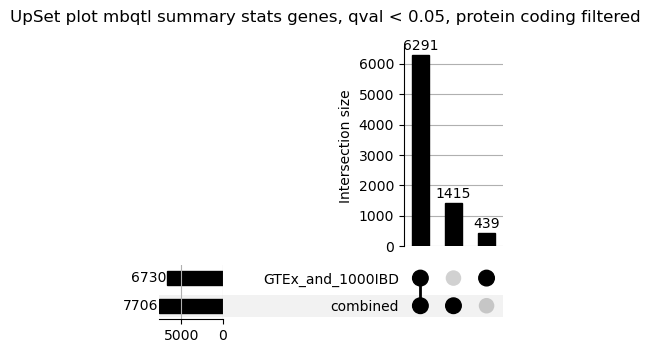

In [14]:
# upset plot of all datasets (gtex, werna, pub)
set1 = set(combined_new["Gene"])
set2 = set(combined_no_pub["Gene"])

set_names = ['combined', 'GTEx_and_1000IBD']
all_elems = set1.union(set2)
all_genes_set = pd.DataFrame([[e in set1, e in set2] for e in all_elems], columns = set_names)
df_up = all_genes_set.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True, sort_by="cardinality")
plt.suptitle("UpSet plot mbqtl summary stats genes, qval < 0.05, protein coding filtered")
plt.show()

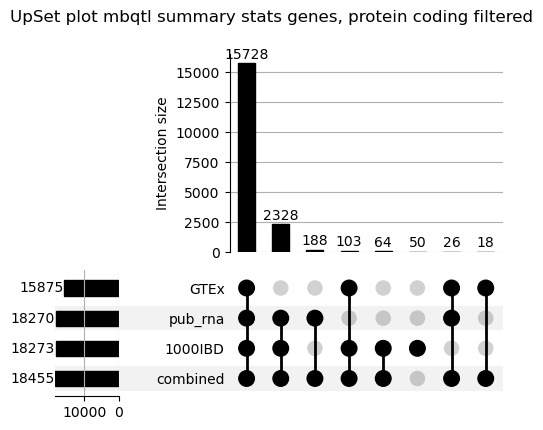

In [11]:
# upset plot of all datasets (gtex, werna, pub)
set1 = set(pub_rna_new_qvalue["Gene"])
set2 = set(werna_new_qvalue["Gene"])
set3 = set(gtex_new_qvalue["Gene"])
set4 = set(combined_new_qvalue["Gene"])

set_names = ['pub_rna', '1000IBD', 'GTEx', 'combined']
all_elems = set1.union(set2).union(set3).union(set4)
all_genes_set = pd.DataFrame([[e in set1, e in set2, e in set3, e in set4] for e in all_elems], columns = set_names)
df_up = all_genes_set.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True, sort_by="cardinality")
plt.suptitle("UpSet plot mbqtl summary stats genes, protein coding filtered")
plt.show()

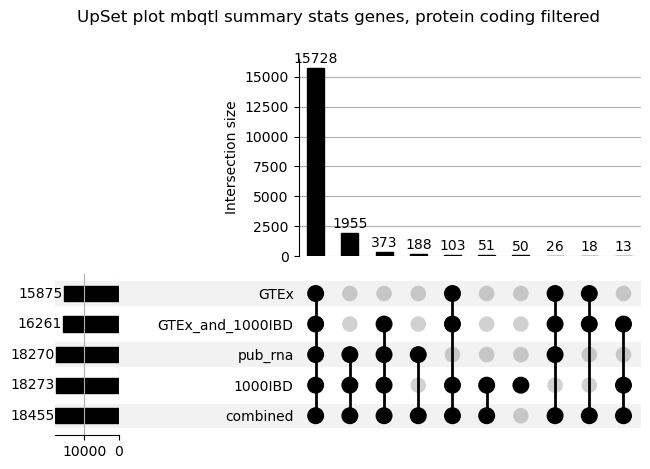

In [13]:
# upset plot of all datasets (gtex, werna, pub)
set1 = set(pub_rna_new_qvalue["Gene"])
set2 = set(werna_new_qvalue["Gene"])
set3 = set(gtex_new_qvalue["Gene"])
set4 = set(combined_new_qvalue["Gene"])
set5 = set(combined_no_pub_qvalue["Gene"])

set_names = ['pub_rna', '1000IBD', 'GTEx', 'combined', 'GTEx_and_1000IBD']
all_elems = set1.union(set2).union(set3).union(set4).union(set5)
all_genes_set = pd.DataFrame([[e in set1, e in set2, e in set3, e in set4, e in set5] for e in all_elems], columns = set_names)
df_up = all_genes_set.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True, sort_by="cardinality")
plt.suptitle("UpSet plot mbqtl summary stats genes, protein coding filtered")
plt.show()

### Old upset plots

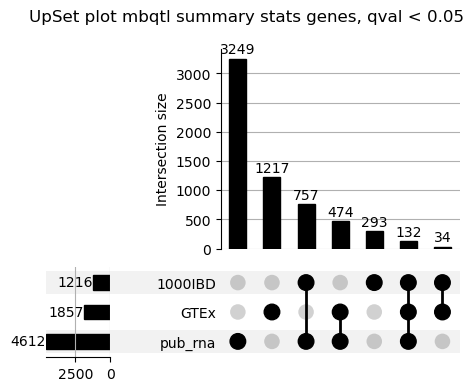

In [23]:
# upset plot of all datasets (gtex, werna, pub)
set1 = set(pub_rna["Gene"])
set2 = set(werna["Gene"])
set3 = set(gtex["Gene"])

set_names = ['pub_rna', '1000IBD', 'GTEx']
all_elems = set1.union(set2).union(set3)
all_genes_set = pd.DataFrame([[e in set1, e in set2, e in set3] for e in all_elems], columns = set_names)
df_up = all_genes_set.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True, sort_by="cardinality")
plt.suptitle("UpSet plot mbqtl summary stats genes, qval < 0.05")
plt.show()

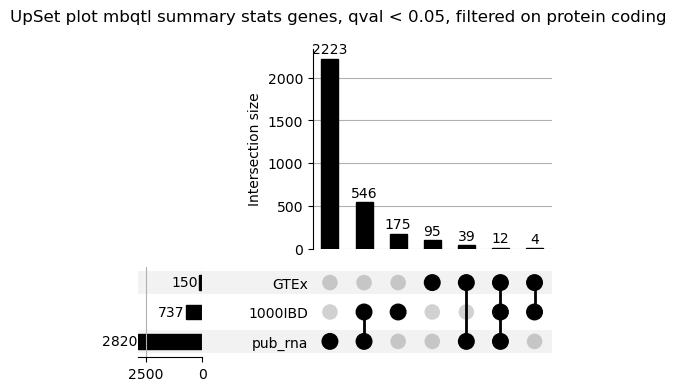

In [24]:
# upset plot of all datasets (gtex, werna, pub) filtered on protein coding genes

set1 = set(pub_rna["Gene"]) & set(genes["Gene"])
set2 = set(werna["Gene"]) & set(genes["Gene"])
set3 = set(gtex["Gene"]) & set(genes["Gene"])

set_names = ['pub_rna', '1000IBD', 'GTEx']
all_elems = set1.union(set2).union(set3)
all_genes_set = pd.DataFrame([[e in set1, e in set2, e in set3] for e in all_elems], columns = set_names)
df_up = all_genes_set.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True, sort_by="cardinality")
plt.suptitle("UpSet plot mbqtl summary stats genes, qval < 0.05, filtered on protein coding")
plt.show()

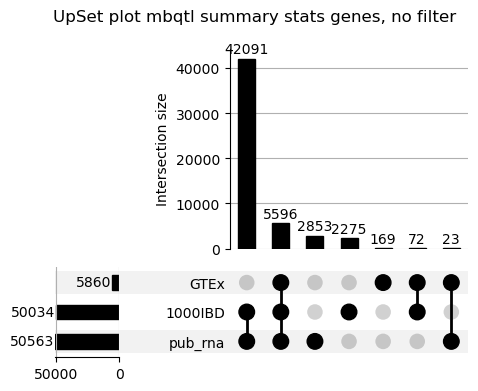

In [25]:
# upset plot of all datasets (gtex, werna, pub) before the qvalue filter
set1 = set(all_topeffects_pub_rna["Gene"])
set2 = set(all_topeffects_werna["Gene"])
set3 = set(all_topeffects_gtex["Gene"])

set_names = ['pub_rna', '1000IBD', 'GTEx']
all_elems = set1.union(set2).union(set3)
all_genes_set = pd.DataFrame([[e in set1, e in set2, e in set3] for e in all_elems], columns = set_names)
df_up = all_genes_set.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True, sort_by="cardinality")
plt.suptitle("UpSet plot mbqtl summary stats genes, no filter")
plt.show()

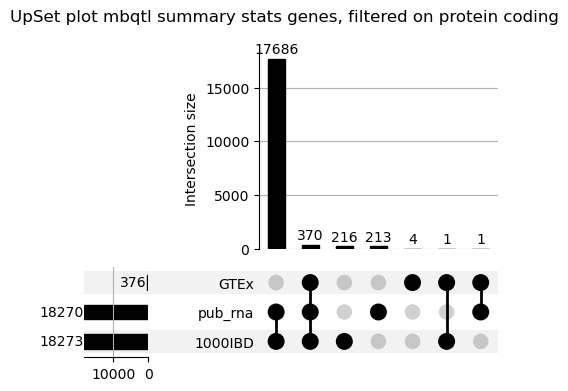

In [26]:
# upset plot of all datasets (gtex, werna, pub) before the qvalue filter
set1 = set(all_topeffects_pub_rna["Gene"]) & set(genes["Gene"])
set2 = set(all_topeffects_werna["Gene"]) & set(genes["Gene"])
set3 = set(all_topeffects_gtex["Gene"]) & set(genes["Gene"])

set_names = ['pub_rna', '1000IBD', 'GTEx']
all_elems = set1.union(set2).union(set3)
all_genes_set = pd.DataFrame([[e in set1, e in set2, e in set3] for e in all_elems], columns = set_names)
df_up = all_genes_set.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True, sort_by="cardinality")
plt.suptitle("UpSet plot mbqtl summary stats genes, filtered on protein coding")
plt.show()

### Top All effects intersection scatter plots

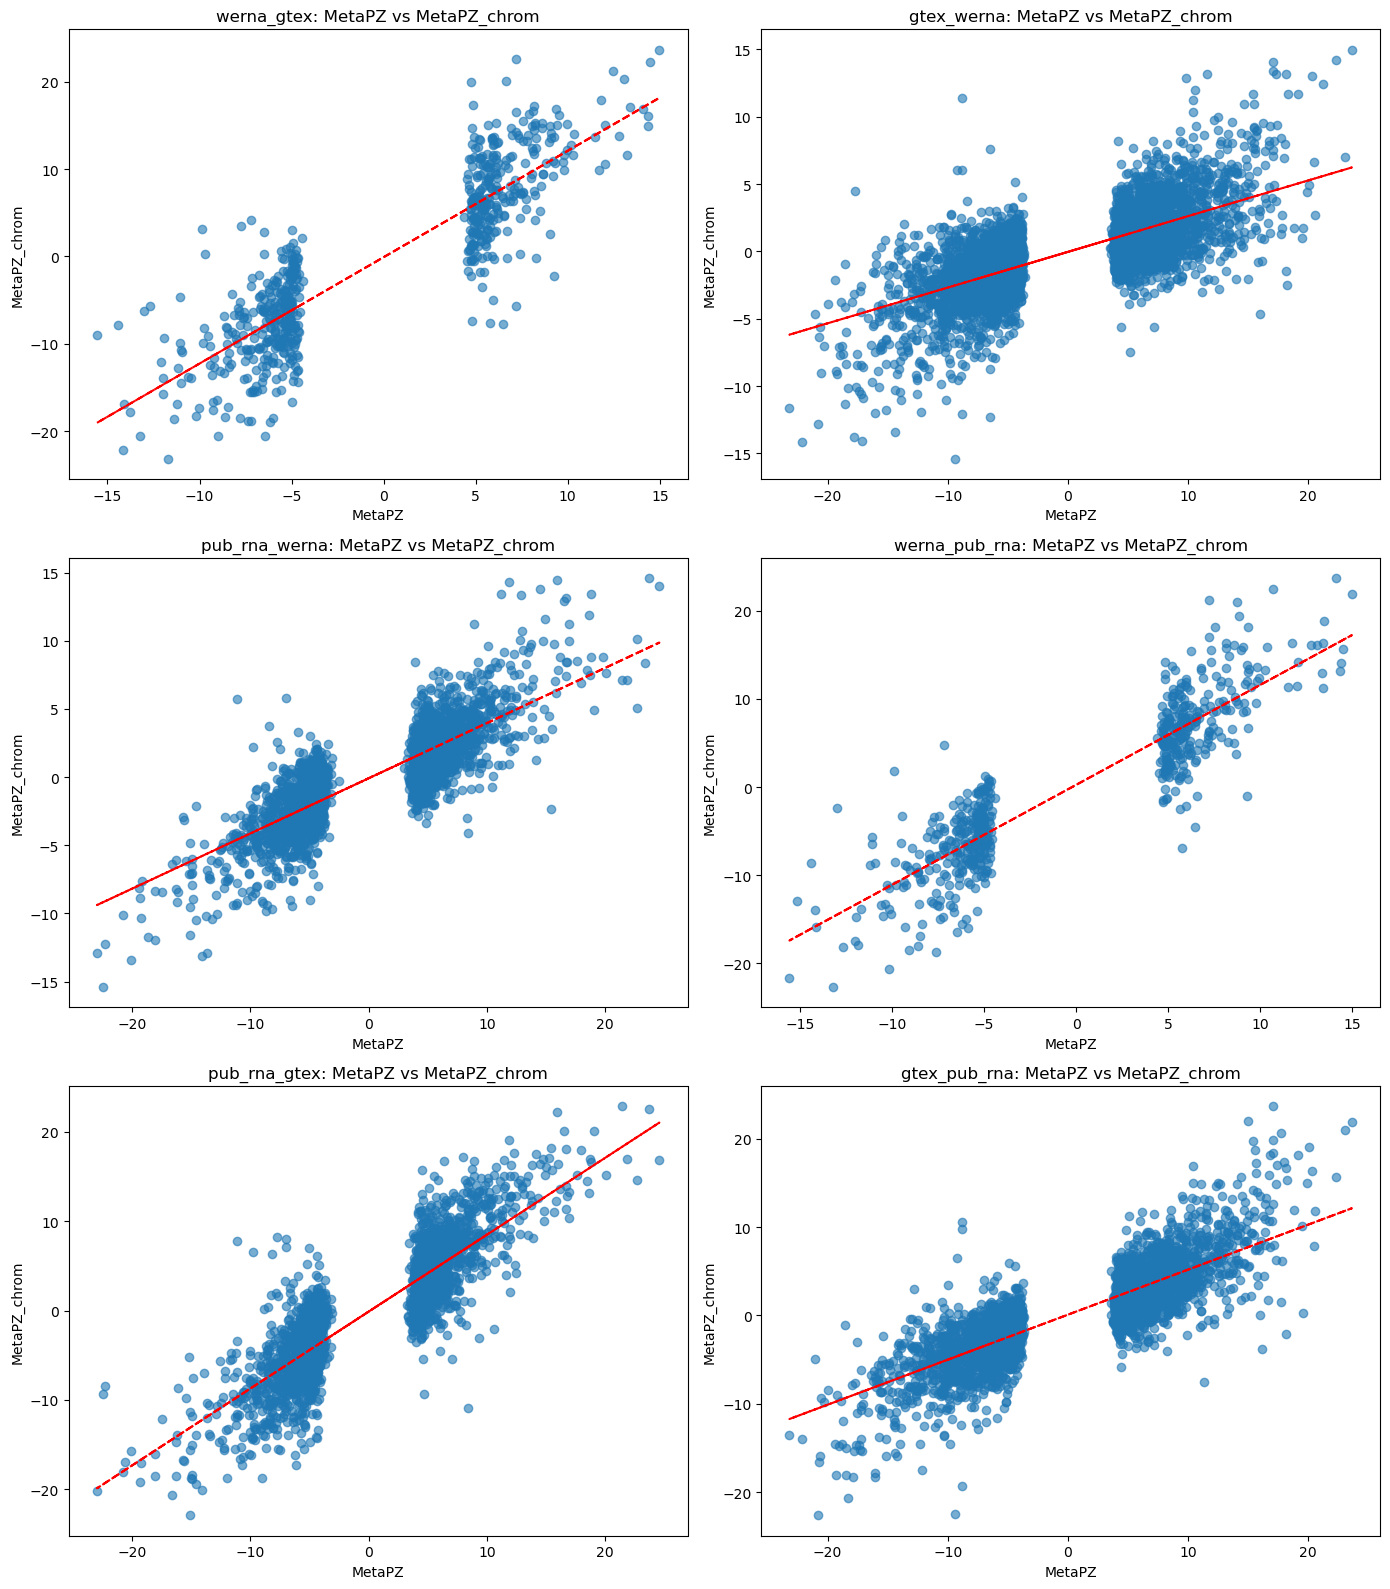

In [12]:
dataframes = [
    ('werna_gtex', werna_gtex),
    ('gtex_werna', gtex_werna),
    ('pub_rna_werna', pub_rna_werna),
    ('werna_pub_rna', werna_pub_rna),
    ('pub_rna_gtex', pub_rna_gtex),
    ('gtex_pub_rna', gtex_pub_rna)
]

# Set up subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
axes = axes.flatten()

# Plot MetaPZ vs MetaPZ_chrom for each dataframe and add trendlines
for i, (name, df) in enumerate(dataframes):
    x = df['MetaPZ']
    y = df['MetaPZ_chrom']
    
    # Scatter plot
    axes[i].scatter(x, y, alpha=0.6)
    
    # Add trendline
    z = np.polyfit(x, y, 1)  # Fit linear regression (1st-degree polynomial)
    p = np.poly1d(z)
    axes[i].plot(x, p(x), "r--")  # Plot the trendline in red dashed style
    
    # Labels and titles
    axes[i].set_title(f'{name}: MetaPZ vs MetaPZ_chrom')
    axes[i].set_xlabel('MetaPZ')
    axes[i].set_ylabel('MetaPZ_chrom')

plt.tight_layout()
plt.show()

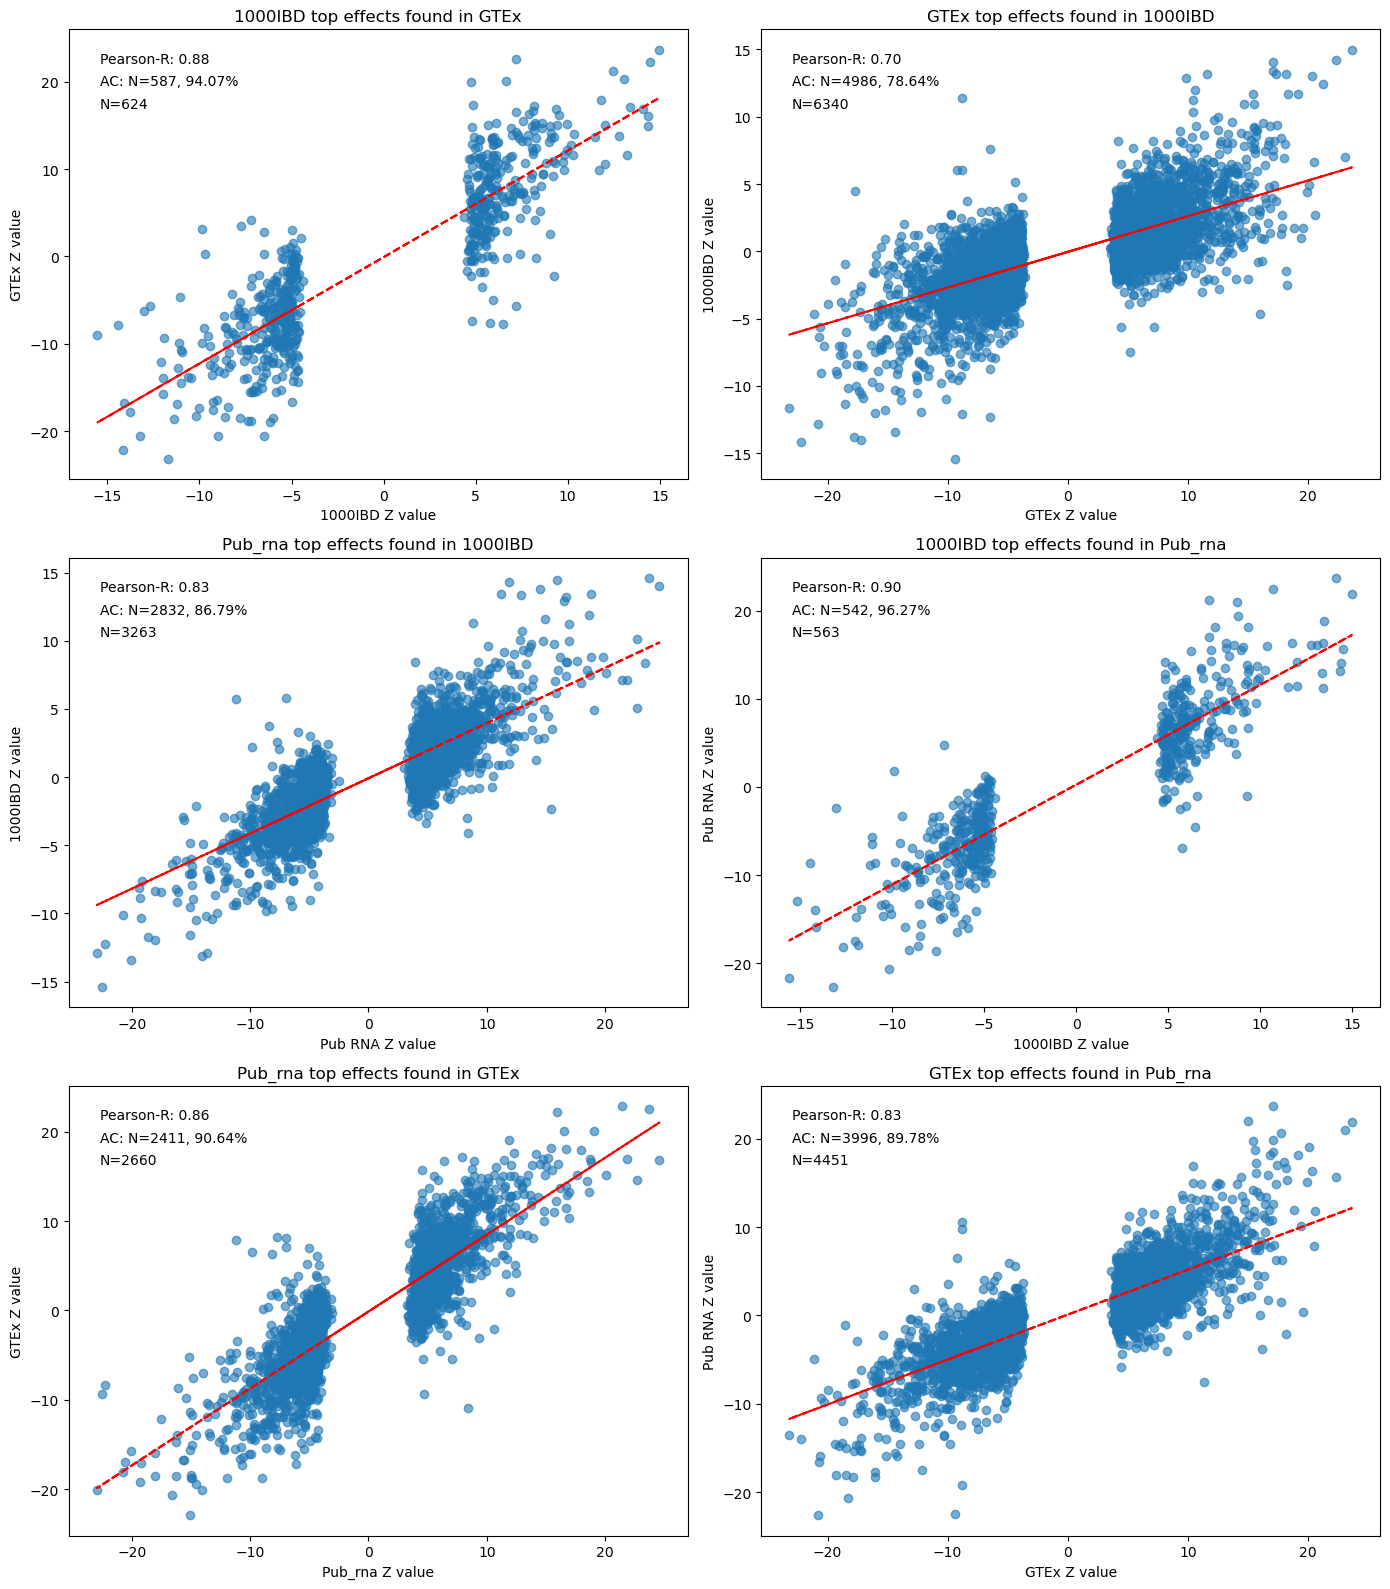

In [41]:
# Sample dataframes for demonstration (replace with your actual dataframes)
# Assuming werna_gtex, gtex_werna, etc. are pre-defined DataFrames
dataframes = [
    ('1000IBD top effects found in GTEx', werna_gtex, '1000IBD Z value', 'GTEx Z value'),
    ('GTEx top effects found in 1000IBD', gtex_werna, 'GTEx Z value', '1000IBD Z value'),
    ('Pub_rna top effects found in 1000IBD', pub_rna_werna, 'Pub RNA Z value', '1000IBD Z value'),
    ('1000IBD top effects found in Pub_rna', werna_pub_rna, '1000IBD Z value', 'Pub RNA Z value'),
    ('Pub_rna top effects found in GTEx', pub_rna_gtex, 'Pub_rna Z value', 'GTEx Z value'),
    ('GTEx top effects found in Pub_rna', gtex_pub_rna, 'GTEx Z value', 'Pub RNA Z value')
]

# Set up subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
axes = axes.flatten()

# Function to calculate Allelic Concordance
def calculate_allelic_concordance(x, y):
    # Remove NaN values
    valid_idx = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid_idx]
    y_valid = y[valid_idx]

    # Get the count of values that share the same direction
    same_direction_count = np.sum(np.sign(x_valid) == np.sign(y_valid))
    total_valid_points = len(x_valid)
    same_direction_percentage = (same_direction_count / total_valid_points * 100) if total_valid_points > 0 else 0
    
    return same_direction_count, same_direction_percentage, total_valid_points

# Plot MetaPZ vs MetaPZ_chrom for each dataframe and add trendlines
for i, (name, df, xlabel, ylabel) in enumerate(dataframes):
    x = df['MetaPZ']
    y = df['MetaPZ_chrom']
    
    # Scatter plot
    axes[i].scatter(x, y, alpha=0.6)
    
    # Add trendline
    z = np.polyfit(x, y, 1)  # Fit linear regression (1st-degree polynomial)
    p = np.poly1d(z)
    axes[i].plot(x, p(x), "r--")  # Plot the trendline in red dashed style
    
    # Calculate Pearson's r and Allelic Concordance
    pearson_r, _ = pearsonr(x.dropna(), y.dropna())
    ac_count, ac_percentage, n = calculate_allelic_concordance(x, y)

    # Labels and titles
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel(xlabel)  # Set x-axis label dynamically
    axes[i].set_ylabel(ylabel)  # Set y-axis label dynamically
    
    # Display Pearson-R, AC, and N on the plot
    axes[i].text(0.05, 0.95, f'Pearson-R: {pearson_r:.2f}', ha='left', va='top', transform=axes[i].transAxes)
    axes[i].text(0.05, 0.90, f'AC: N={ac_count}, {ac_percentage:.2f}%', ha='left', va='top', transform=axes[i].transAxes)
    axes[i].text(0.05, 0.85, f'N={n}', ha='left', va='top', transform=axes[i].transAxes)

plt.tight_layout()
plt.show()


### Other plots

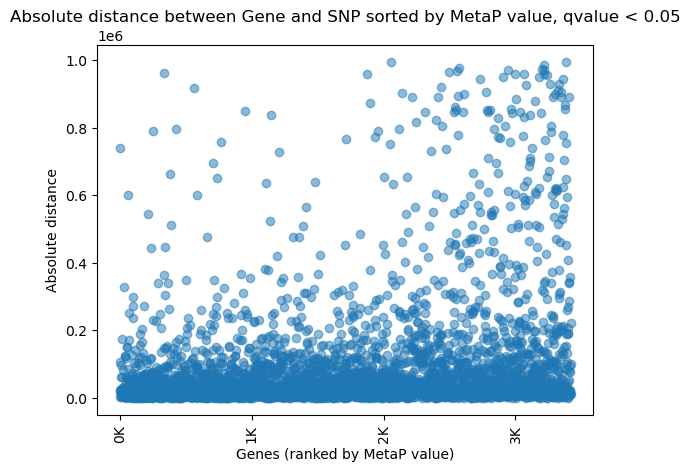

In [15]:
pub_rna_subset = pub_rna_new[["Gene", "MetaP", "SNPPos", "GenePos"]].sort_values(by="MetaP")
pub_rna_subset["DistanceAbsolute"] = abs(pub_rna_subset["SNPPos"] - pub_rna_subset["GenePos"])

# Use the index of the genes instead of their names for the x-axis
plt.scatter(pub_rna_subset.index, pub_rna_subset.DistanceAbsolute, alpha=0.5)

# Format the x-axis to display ticks in thousands
def thousands_formatter(x, pos):
    return '%1.0fK' % (x * 1e-3)

# Apply the formatter to the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

# Optionally, set x-axis ticks at intervals of 1000
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1000))

# Set labels and title
plt.xticks(rotation="vertical")
plt.xlabel("Genes (ranked by MetaP value)")
plt.ylabel("Absolute distance")
plt.title("Absolute distance between Gene and SNP sorted by MetaP value, qvalue < 0.05")

# Show the plot
plt.show()


Text(0.5, 1.0, 'Abosulute distance between Gene and SNP, qvalue < 0.05')

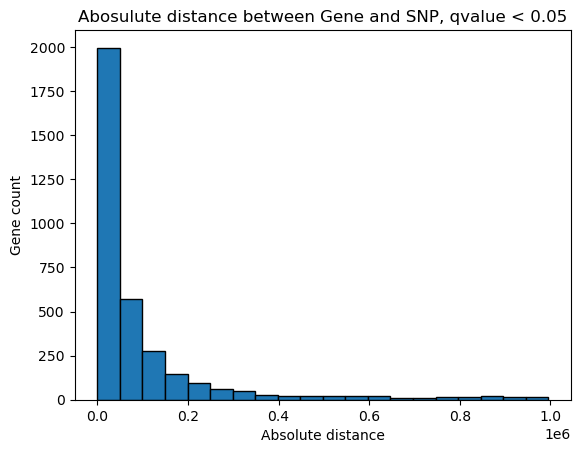

In [19]:
plt.hist(pub_rna_subset["DistanceAbsolute"], bins=20, edgecolor = "black")
plt.xlabel("Absolute distance")
plt.ylabel("Gene count")
plt.title("Abosulute distance between Gene and SNP, qvalue < 0.05")

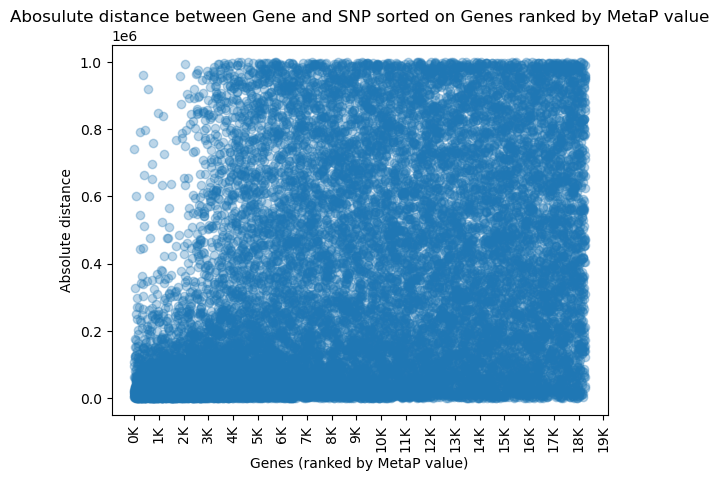

In [17]:
pub_rna_subset_qvalue = pub_rna_new_qvalue[["Gene","MetaP","SNPPos","GenePos"]].sort_values(by="MetaP")
pub_rna_subset_qvalue["DistanceAbsolute"] = abs(pub_rna_subset_qvalue["SNPPos"] - pub_rna_subset_qvalue["GenePos"])

# Use the index of the genes instead of their names for the x-axis
plt.scatter(pub_rna_subset_qvalue.index, pub_rna_subset_qvalue.DistanceAbsolute, alpha=0.3)

# Format the x-axis to display ticks in thousands
def thousands_formatter(x, pos):
    return '%1.0fK' % (x * 1e-3)

# Apply the formatter to the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

# Optionally, set x-axis ticks at intervals of 1000
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1000))

# Set labels and title
plt.xticks(rotation="vertical")
plt.xlabel("Genes (ranked by MetaP value)")
plt.ylabel("Absolute distance")
plt.title("Abosulute distance between Gene and SNP sorted on Genes ranked by MetaP value")

# Show the plot
plt.show()

Text(0.5, 1.0, 'Abosulute distance between Gene and SNP')

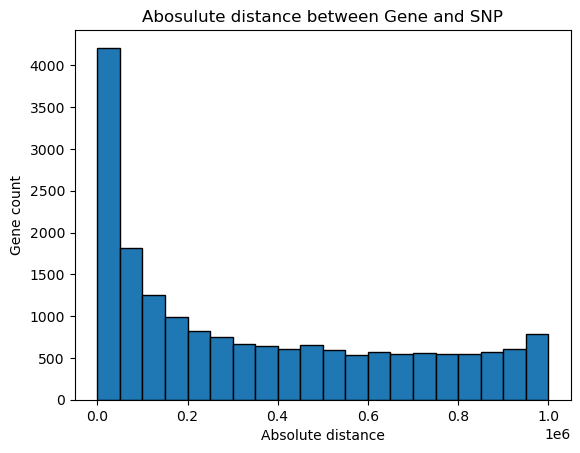

In [18]:
plt.hist(pub_rna_subset_qvalue["DistanceAbsolute"], bins=20, edgecolor = "black")
plt.xlabel("Absolute distance")
plt.ylabel("Gene count")
plt.title("Absolute distance between Gene and SNP")

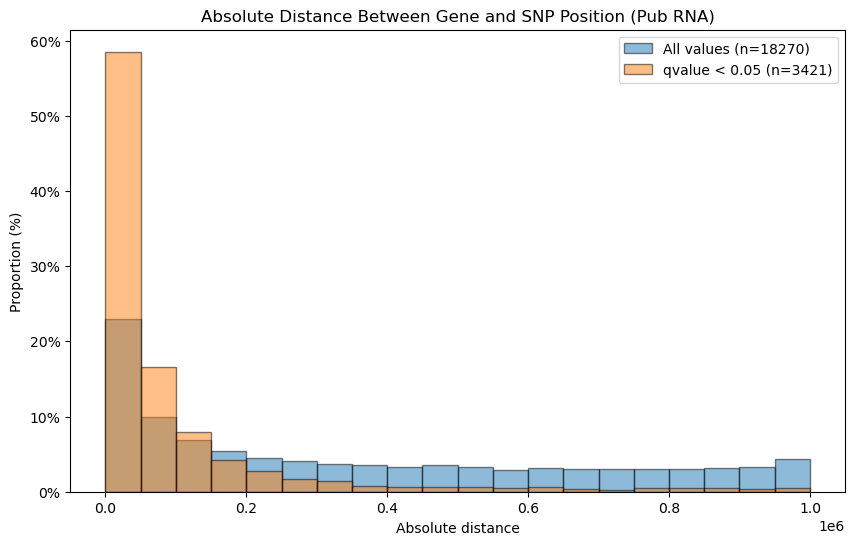

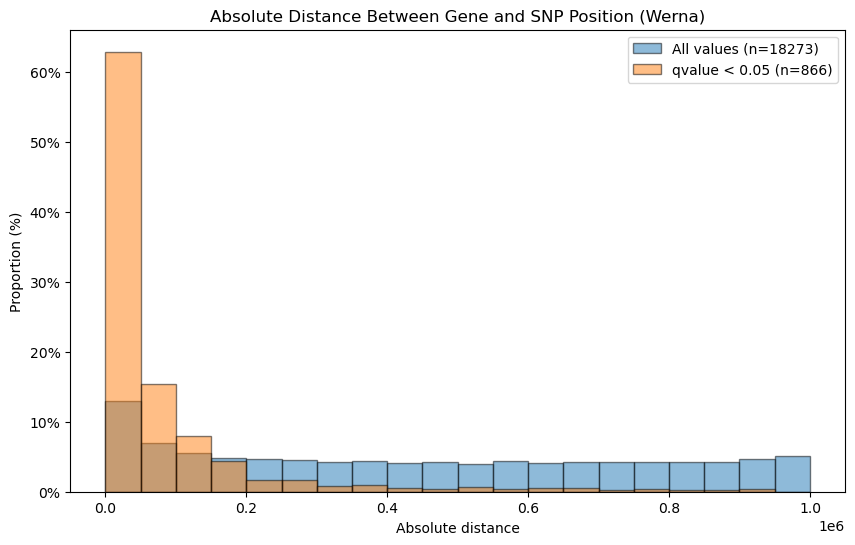

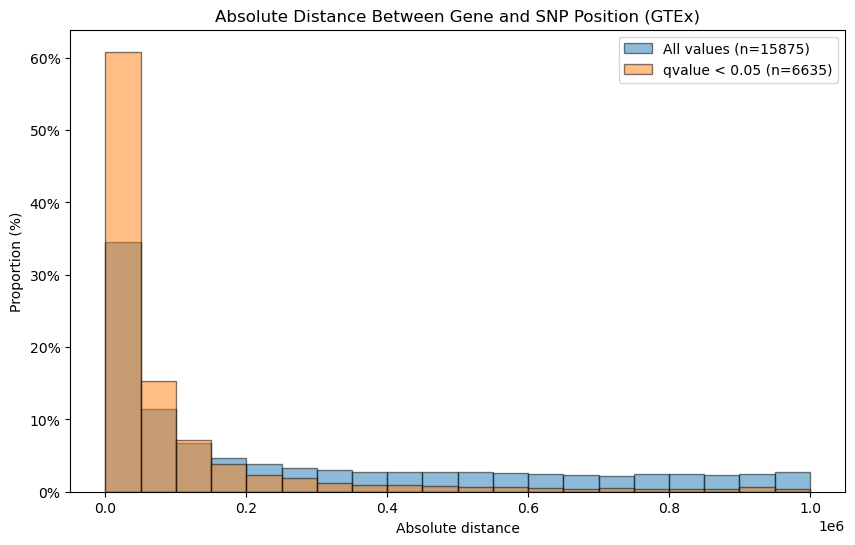

In [39]:
# Find the minimum and maximum distance values across all datasets
min_val = min(gtex_subset["DistanceAbsolute"].min(), werna_subset["DistanceAbsolute"].min(), pub_rna_subset["DistanceAbsolute"].min())
max_val = max(gtex_subset["DistanceAbsolute"].max(), werna_subset["DistanceAbsolute"].max(), pub_rna_subset["DistanceAbsolute"].max())

# Create consistent bin edges for all datasets
bins = np.linspace(min_val, max_val, 21)  # 20 bins, so 21 edges

# Modify the plot_histogram function to use these bin edges
def plot_histogram(dataset_name, subset_all, subset_qvalue):
    total_genes_all = len(subset_all)
    total_genes_qvalue = len(subset_qvalue)

    plt.figure(figsize=(10, 6))
    plt.hist(
        subset_qvalue["DistanceAbsolute"], 
        bins=bins,  # Use predefined bin edges
        weights=np.ones(len(subset_qvalue)) / total_genes_qvalue,  # Normalize to get proportions
        edgecolor="black", 
        alpha=0.5, 
        label=f"All values (n={total_genes_qvalue})"
    )

    plt.hist(
        subset_all["DistanceAbsolute"], 
        bins=bins,  # Use predefined bin edges
        weights=np.ones(len(subset_all)) / total_genes_all,  # Normalize to get proportions
        edgecolor="black", 
        alpha=0.5, 
        label=f"qvalue < 0.05 (n={total_genes_all})"
    )


    # Add labels and title
    plt.xlabel("Absolute distance")
    plt.ylabel("Proportion (%)")
    plt.title(f"Absolute Distance Between Gene and SNP Position ({dataset_name})")

    # Convert y-axis to percentage
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    # Add a legend to differentiate the two histograms
    plt.legend()

    # Show the plot
    plt.show()

    # Dataset 1: pub_rna_subset
pub_rna_subset = pub_rna_new[["Gene", "MetaP", "SNPPos", "GenePos"]].sort_values(by="MetaP")
pub_rna_subset["DistanceAbsolute"] = abs(pub_rna_subset["SNPPos"] - pub_rna_subset["GenePos"])
pub_rna_subset_qvalue = pub_rna_new_qvalue[["Gene", "MetaP", "SNPPos", "GenePos"]].sort_values(by="MetaP")
pub_rna_subset_qvalue["DistanceAbsolute"] = abs(pub_rna_subset_qvalue["SNPPos"] - pub_rna_subset_qvalue["GenePos"])

plot_histogram("Pub RNA", pub_rna_subset, pub_rna_subset_qvalue)

# Dataset 2: werna_subset
werna_subset = werna_new[["Gene", "MetaP", "SNPPos", "GenePos"]].sort_values(by="MetaP")
werna_subset["DistanceAbsolute"] = abs(werna_subset["SNPPos"] - werna_subset["GenePos"])
werna_subset_qvalue = werna_new_qvalue[["Gene", "MetaP", "SNPPos", "GenePos"]].sort_values(by="MetaP")
werna_subset_qvalue["DistanceAbsolute"] = abs(werna_subset_qvalue["SNPPos"] - werna_subset_qvalue["GenePos"])

plot_histogram("Werna", werna_subset, werna_subset_qvalue)

# Dataset 3: gtex_subset
gtex_subset = gtex_new[["Gene", "MetaP", "SNPPos", "GenePos"]].sort_values(by="MetaP")
gtex_subset["DistanceAbsolute"] = abs(gtex_subset["SNPPos"] - gtex_subset["GenePos"])
gtex_subset_qvalue = gtex_new_qvalue[["Gene", "MetaP", "SNPPos", "GenePos"]].sort_values(by="MetaP")
gtex_subset_qvalue["DistanceAbsolute"] = abs(gtex_subset_qvalue["SNPPos"] - gtex_subset_qvalue["GenePos"])

# Plot Dataset 3: GTEx
plot_histogram("GTEx", gtex_subset, gtex_subset_qvalue)


### test graphs

Text(0.5, 1.0, 'Histogram of the Allele Frequency (AF), qvalue < 0.05 ,pub rna summary stats')

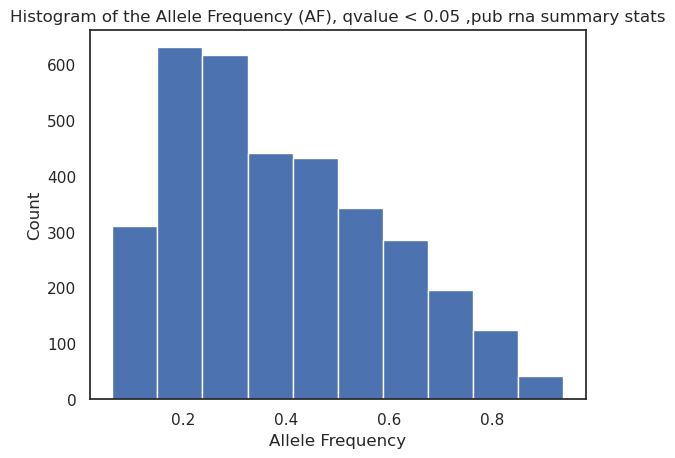

In [63]:
plt.hist(pub_rna_new.SNPEffectAlleleFreq)
plt.xlabel("Allele Frequency")
plt.ylabel("Count")
plt.title("Histogram of the Allele Frequency (AF), qvalue < 0.05 ,pub rna summary stats")

Text(0.5, 1.0, 'Histogram of the Allele Frequency (AF), pub rna summary stats')

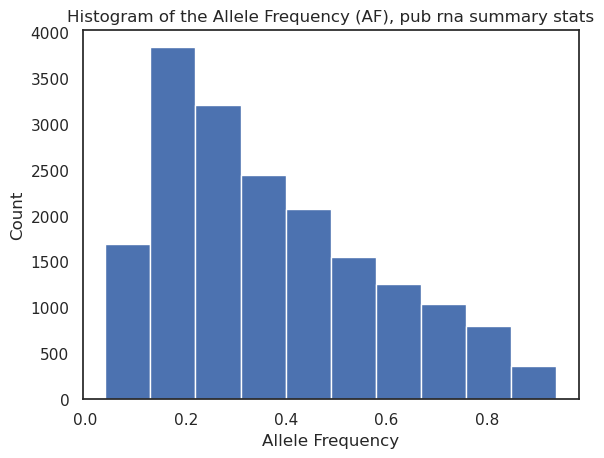

In [62]:
plt.hist(pub_rna_new_qvalue.SNPEffectAlleleFreq)
plt.xlabel("Allele Frequency")
plt.ylabel("Count")
plt.title("Histogram of the Allele Frequency (AF), pub rna summary stats")

Text(0.5, 1.0, 'Histogram of the Allele, qvalue < 0.05, if AF > 0.5, 1 - AF')

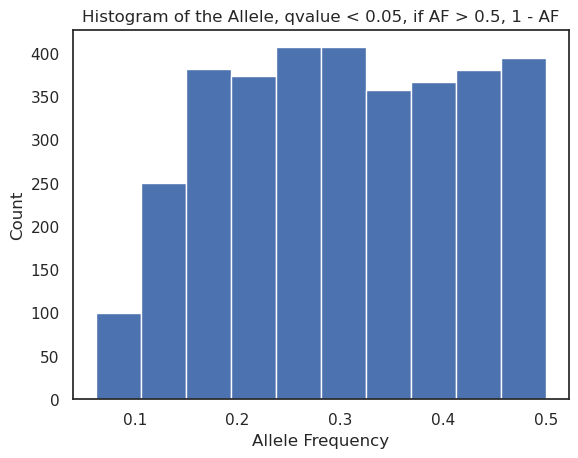

In [52]:
pub_rna_af = pub_rna_new.copy()
pub_rna_af['newAF'] = pub_rna_af['SNPEffectAlleleFreq'].apply(lambda x: 1 - x if x > 0.5 else x)
plt.hist(pub_rna_af.newAF)
plt.xlabel("Allele Frequency")
plt.ylabel("Count")
plt.title("Histogram of the Allele, qvalue < 0.05, if AF > 0.5, 1 - AF")

Text(0.5, 1.0, 'Histogram of the Allele, if AF > 0.5, 1 - AF')

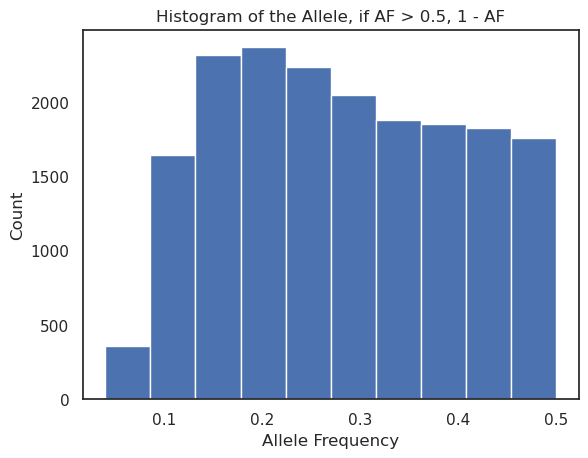

In [54]:
pub_rna_af_qvalue = pub_rna_new_qvalue.copy()
pub_rna_af_qvalue['newAF'] = pub_rna_af_qvalue['SNPEffectAlleleFreq'].apply(lambda x: 1 - x if x > 0.5 else x)
plt.hist(pub_rna_af_qvalue.newAF)
plt.xlabel("Allele Frequency")
plt.ylabel("Count")
plt.title("Histogram of the Allele, if AF > 0.5, 1 - AF")

### Heatmap

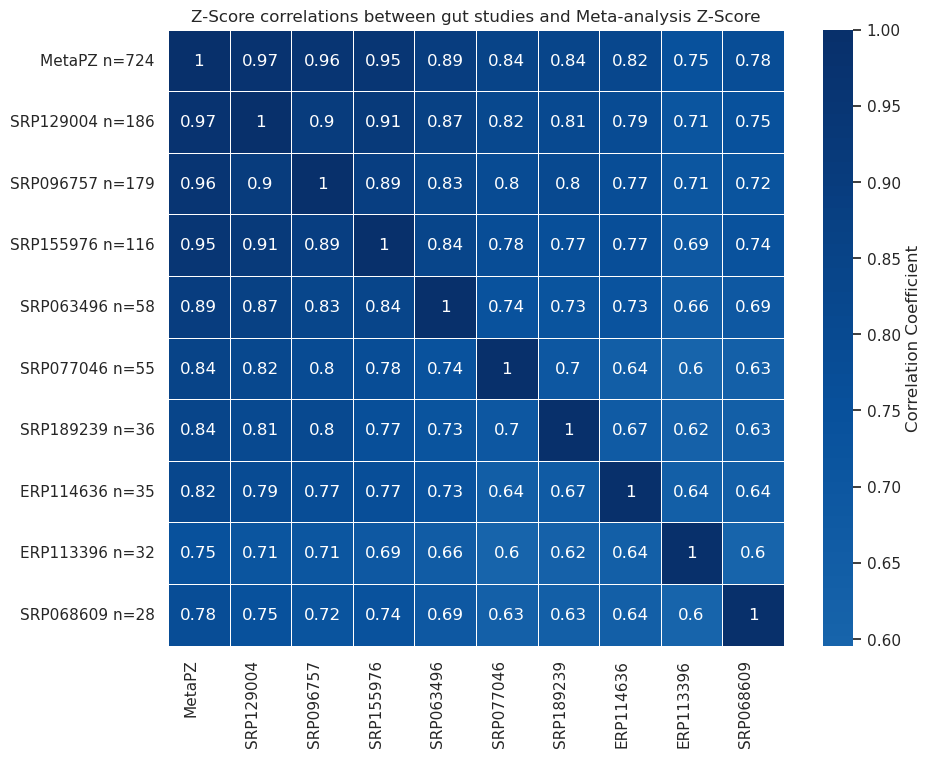

In [58]:
# Define a function to extract dataset size and handle "MetaPZ"
def get_dataset_size(label):
    if label == 'MetaPZ':
        return float('inf')  # Assign a very large value to prioritize it last
    else:
        return int(label.split('n=')[-1])

# Define different labels for x and y axes
x_labels = ['MetaPZ', 'ERP113396', 'ERP114636', 'SRP063496', 'SRP068609', 'SRP077046',
            'SRP096757', 'SRP129004', 'SRP155976', 'SRP189239']
y_labels = ['MetaPZ n=724', 'ERP113396 n=32', 'ERP114636 n=35', 'SRP063496 n=58', 'SRP068609 n=28', 'SRP077046 n=55',
            'SRP096757 n=179', 'SRP129004 n=186', 'SRP155976 n=116', 'SRP189239 n=36']

# Extract dataset sizes from y_labels
dataset_sizes = [get_dataset_size(label) for label in y_labels]

# Sort x and y labels and sizes together based on dataset size (descending order)
sorted_indices = np.argsort(dataset_sizes)[::-1]  # Descending order
sorted_x_labels = [x_labels[i] for i in sorted_indices]
sorted_y_labels = [y_labels[i] for i in sorted_indices]

# Split the 'DatasetZScores' column into separate columns
dataset_columns = filtered_mbqtl['DatasetZScores'].str.split(';', expand=True)

# Convert dataset columns to numeric values, replace '-' with NaN
dataset_columns = dataset_columns.replace('-', np.nan).apply(pd.to_numeric)

# Concatenate MetaPZ and dataset columns
df = pd.concat([filtered_mbqtl[['MetaPZ']], dataset_columns], axis=1)

# Sort the dataframe columns based on sorted indices
df_sorted = df.iloc[:, sorted_indices]

# Calculate the pairwise correlation matrix
pairwise_corr = df_sorted.corr()

# Plotting the pairwise correlation matrix
sns.set_theme(style="white")
mask = np.triu(np.ones_like(pairwise_corr, dtype=bool))  # Mask to avoid duplicate plots
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(pairwise_corr, annot=True, cmap='Blues', center=0, square=True, linewidths=0.5, 
                      cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Z-Score correlations between gut studies and Meta-analysis Z-Score")

# Set x-axis and y-axis labels
heatmap.set_xticklabels(sorted_x_labels, rotation=90, ha='right')
heatmap.set_yticklabels(sorted_y_labels, rotation=0)

plt.show()

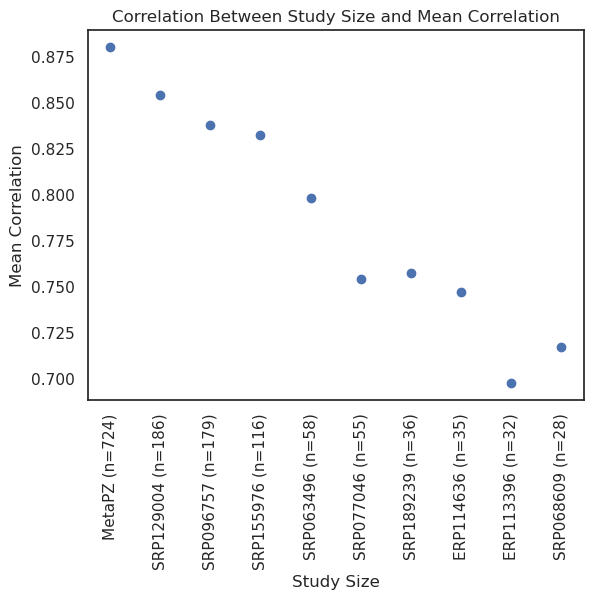

In [38]:
data = {
    "mean_correlation": [0.880516, 0.854018, 0.837940, 0.832740, 0.798118, 0.754275, 0.757460, 0.747086, 0.697556, 0.716877],
    "studies": ["MetaPZ", "SRP129004", "SRP096757", "SRP155976", "SRP063496", "SRP077046", "SRP189239", "ERP114636", "ERP113396", "SRP068609"],
    "size": ["724", "186", "179", "116", "58", "55", "36", "35", "32", "28"]
}

df = pd.DataFrame(data)

# Create a scatter plot with labels
plt.scatter(df['size'], df['mean_correlation'])

# Add labels and title
plt.xlabel('Study Size')
plt.ylabel('Mean Correlation')
plt.title('Correlation Between Study Size and Mean Correlation')

# Custom x-tick labels: "Study Name (n=Size)"
labels = [f"{name} (n={size})" for name, size in zip(df['studies'], df['size'])]
plt.xticks(df['size'], labels, rotation="vertical")  # Rotate labels for readability

# Show the plot
plt.show()

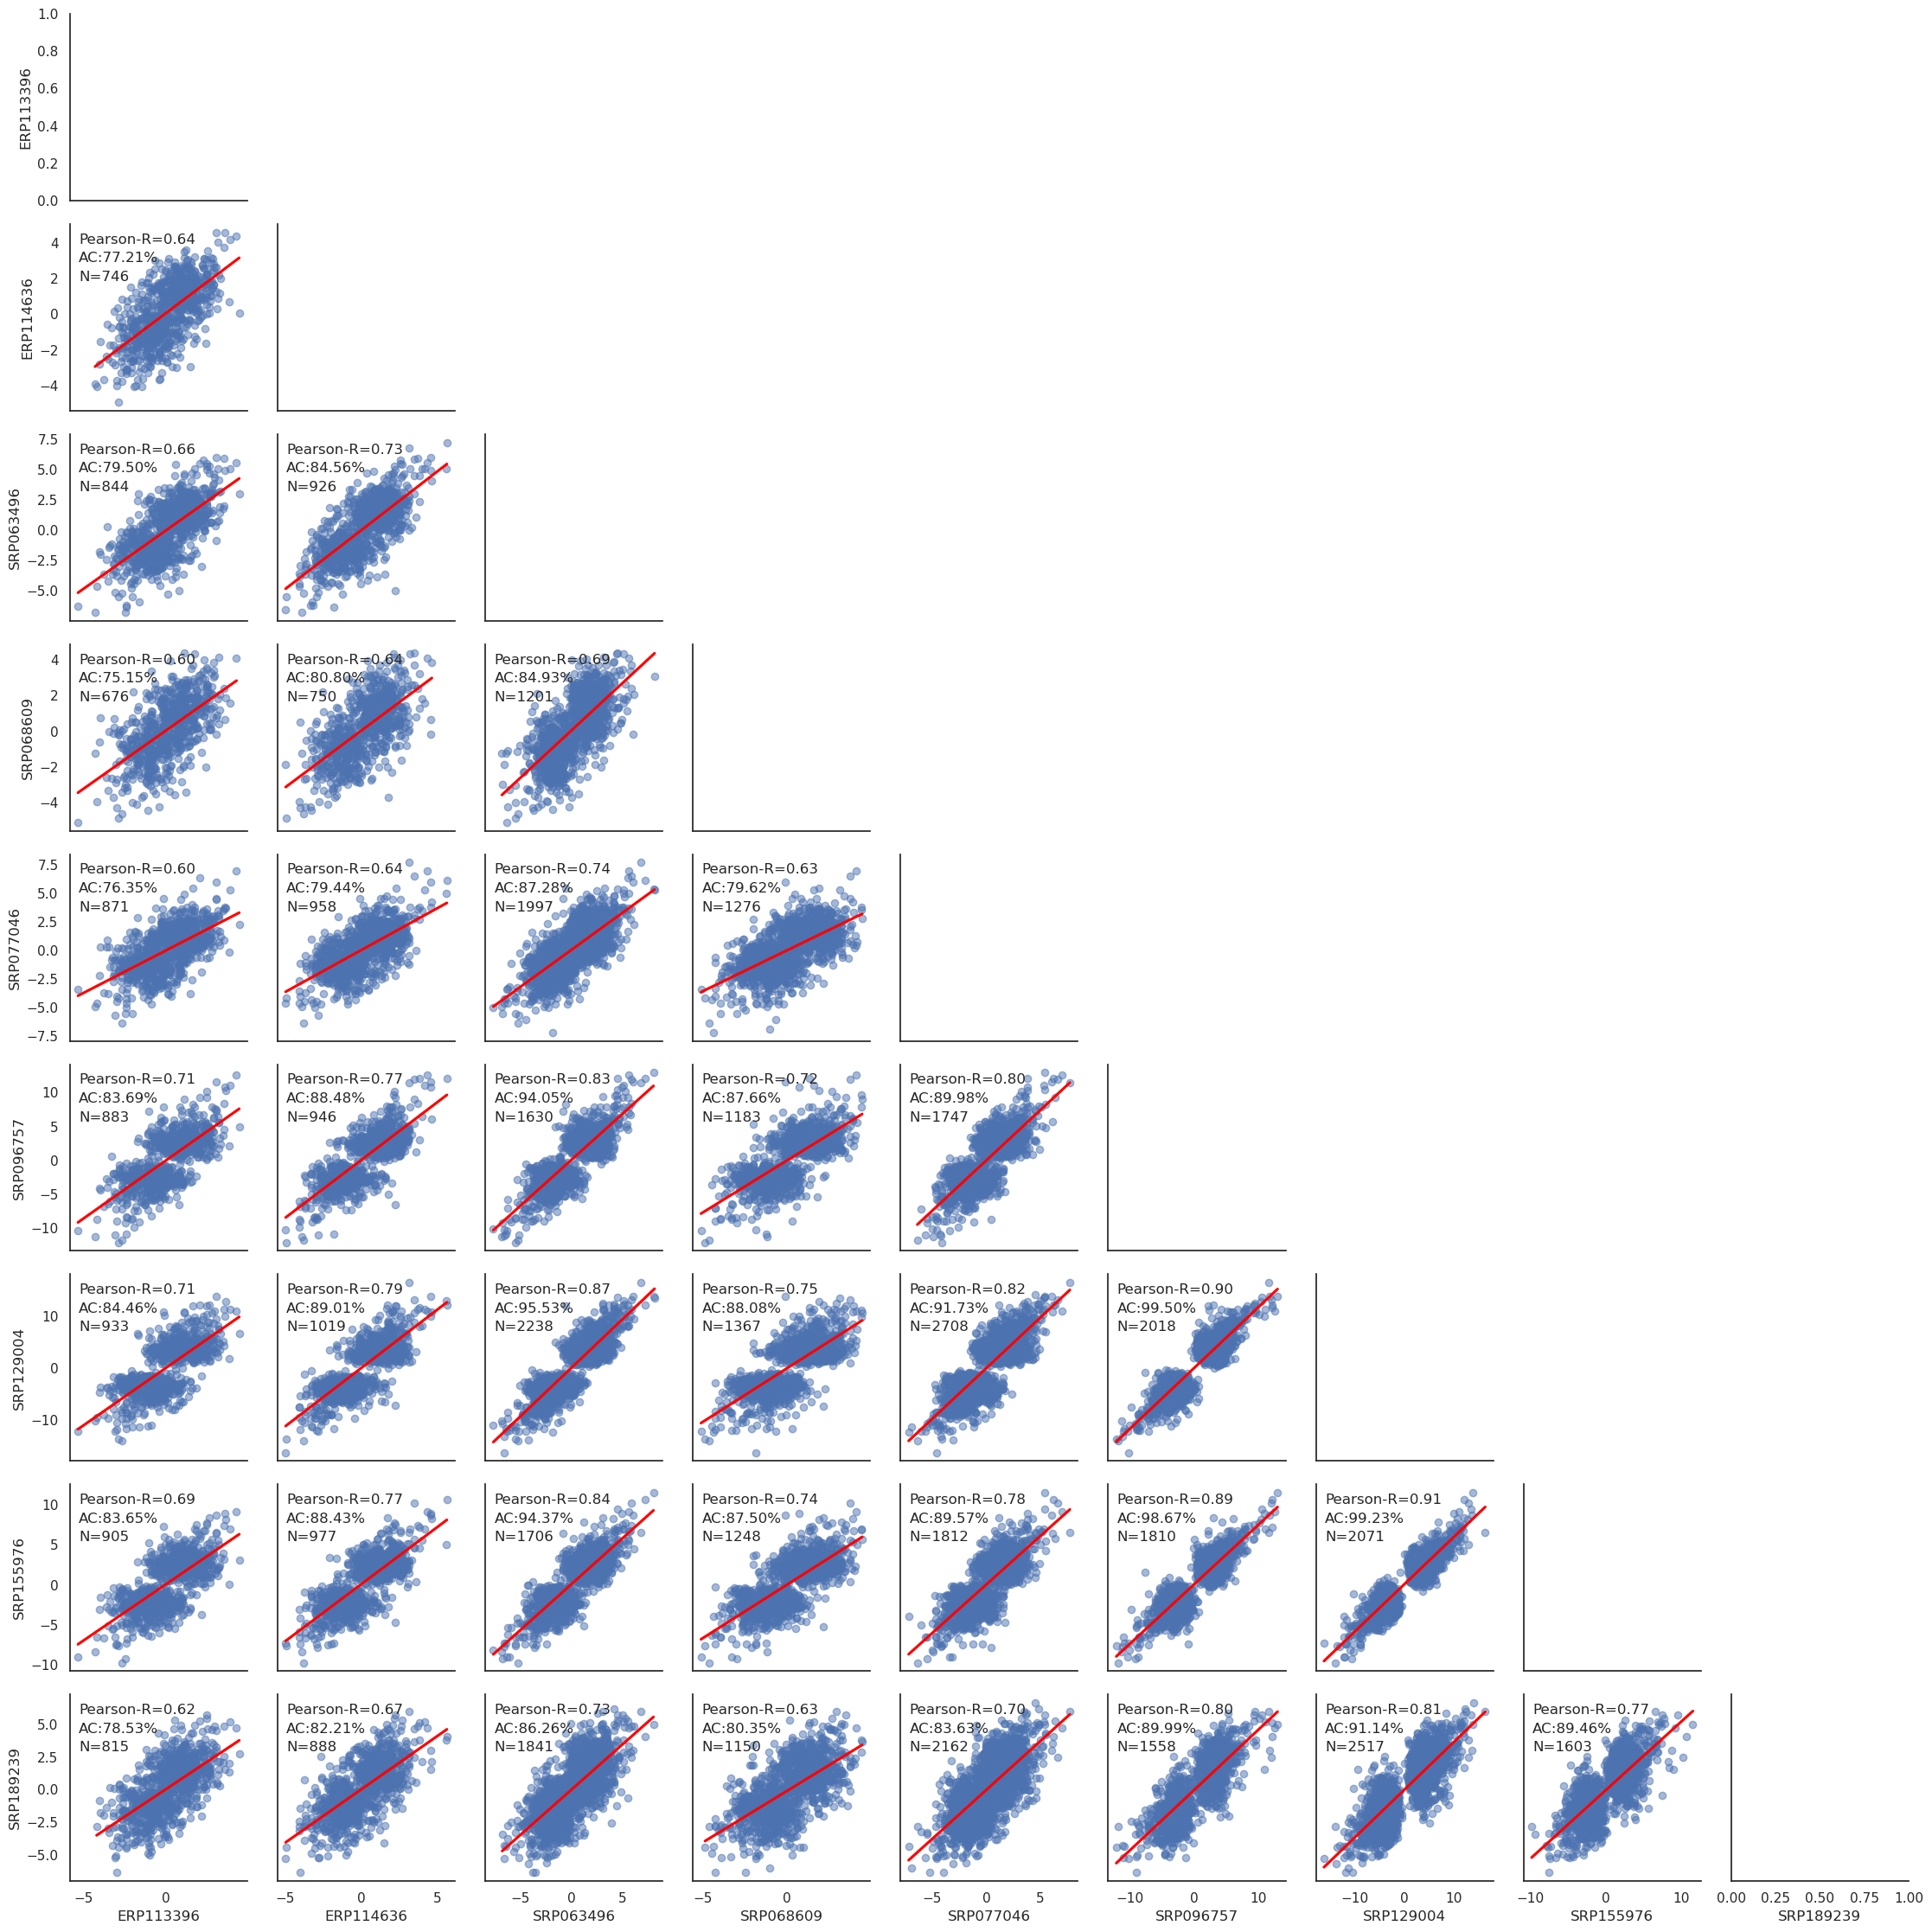

In [60]:
# Create a PairGrid for the scatter plots
g = sns.PairGrid(dataset_columns)

# Define the x_labels and y_labels
labels = ['ERP113396', 'ERP114636', 'SRP063496', 'SRP068609', 'SRP077046',
          'SRP096757', 'SRP129004', 'SRP155976', 'SRP189239']

# Function to calculate Allelic Concordance
def calculate_allelic_concordance(x, y):
    # Remove NaN values
    valid_idx = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid_idx]
    y_valid = y[valid_idx]

    # Get the count of values that share the same direction
    if len(x_valid) > 1:
        same_direction_count = np.sum(np.sign(x_valid) == np.sign(y_valid))
        same_direction_percentage = (same_direction_count / len(x_valid)) * 100 if len(x_valid) > 0 else 0
        return same_direction_count, same_direction_percentage
    return 0, 0.0

# Function to plot scatter with trendline, N, Pearson-R, and Allelic Concordance
def scatter_with_trendline(x, y, **kwargs):
    # Remove NaN values
    valid_idx = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid_idx]
    y_valid = y[valid_idx]

    if len(x_valid) > 1:  # Ensure enough valid points for Pearson-R calculation
        # Scatter plot with trendline
        sns.regplot(x=x_valid, y=y_valid, ci=None, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}, **kwargs)

        # Calculate number of data points (N)
        n = len(x_valid)

        # Calculate Pearson-R
        pearson_r, _ = pearsonr(x_valid, y_valid)

        # Calculate Allelic Concordance
        same_direction_count, same_direction_percentage = calculate_allelic_concordance(x_valid, y_valid)

        # Display Pearson-R, N, and Allelic Concordance
        plt.text(0.05, 0.95, f'Pearson-R={pearson_r:.2f}', ha='left', va='top', transform=plt.gca().transAxes)
        plt.text(0.05, 0.85, f'AC:{same_direction_percentage:.2f}%', ha='left', va='top', transform=plt.gca().transAxes)
        # plt.text(0.05, 0.85, f'AC: N={same_direction_count}, {same_direction_percentage:.2f}%', ha='left', va='top', transform=plt.gca().transAxes)
        plt.text(0.05, 0.75, f'N={n}', ha='left', va='top', transform=plt.gca().transAxes)

# Map the lower triangle with scatter plots including trendlines
g.map_lower(scatter_with_trendline)

# Remove upper triangle and diagonal plots by setting their axes to invisible
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

# Set custom x-axis and y-axis labels
for i, ax in enumerate(g.axes[-1, :]):  # Set the x-axis labels on the bottom
    ax.set_xlabel(labels[i], rotation=0, ha='center')

for i, ax in enumerate(g.axes[:, 0]):  # Set the y-axis labels on the left
    ax.set_ylabel(labels[i], rotation=90, ha='center')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()